# Bonus 1: Numerical Optimization for Logistic Regression.

### Name: [Your-Name?]


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance. (1 bonus point.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Github repo.

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2019F/blob/master/homework/Bonus1/Bonus1.html


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [279]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [280]:
# partition the data to training and test sets
n = x.shape[0]
n_train = int(numpy.ceil(n * 0.8))
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (615, 8)
Shape of x_test: (153, 8)
Shape of y_train: (615, 1)
Shape of y_test: (153, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [281]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.01629479 -0.00485657  0.11666841  0.03951118  0.00525519 -0.00784636
  -0.0397758   0.02086282]]
test std = 
[[1.01160281 1.0389909  0.89426544 0.95009884 1.09797782 0.93950271
  0.88283209 0.98242526]]


## 1.4. Add a dimension of all ones

In [283]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (615, 9)
Shape of x_test: (153, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [284]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [285]:
print(x.shape)

(768, 8)


In [286]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [287]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [288]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [289]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5844215271566097
Objective value at t=2 is 0.5410618019328941
Objective value at t=3 is 0.5176898001870635
Objective value at t=4 is 0.5029495343257528
Objective value at t=5 is 0.4928272567338574
Objective value at t=6 is 0.485510141070479
Objective value at t=7 is 0.4800381736715933
Objective value at t=8 is 0.4758455763517734
Objective value at t=9 is 0.47257345912289267
Objective value at t=10 is 0.46998201949410146
Objective value at t=11 is 0.46790480253207056
Objective value at t=12 is 0.4662228497967258
Objective value at t=13 is 0.46484914953761164
Objective value at t=14 is 0.4637188258999685
Objective value at t=15 is 0.4627827150069705
Objective value at t=16 is 0.462003032429822
Objective value at t=17 is 0.4613503793227188
Objective value at t=18 is 0.46080163067233504
Objective value at t=19 is 0.46033841899436145
Objective value at t=20 is 0.45994602830614256
Objective value at t=21 is 0.4596125758

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [290]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [291]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [292]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.514966284212605
Objective value at epoch t=1 is 0.5039644277628698
Objective value at epoch t=2 is 0.5054873083700749
Objective value at epoch t=3 is 0.4975189742252864
Objective value at epoch t=4 is 0.4922093787631616
Objective value at epoch t=5 is 0.484182394913068
Objective value at epoch t=6 is 0.48427569432082085
Objective value at epoch t=7 is 0.48279518408731953
Objective value at epoch t=8 is 0.48491225815694844
Objective value at epoch t=9 is 0.4693154275279669
Objective value at epoch t=10 is 0.480158204844555
Objective value at epoch t=11 is 0.4758493702778725
Objective value at epoch t=12 is 0.4700793449321492
Objective value at epoch t=13 is 0.47177586919480685
Objective value at epoch t=14 is 0.47261230854006087
Objective value at epoch t=15 is 0.46807118446301826
Objective value at epoch t=16 is 0.46828813034432937
Objective value at epoch t=17 is 0.46644069210157335
Objective value at epoch t=18 is 0.467328027858299
Objective value at

# 4. Compare GD with SGD

Plot objective function values against epochs.

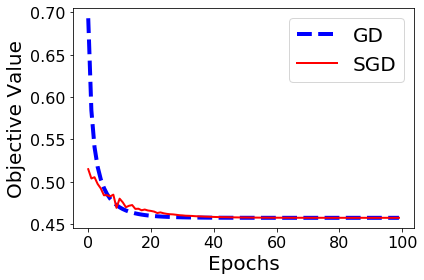

In [293]:
#!/usr/bin/env python
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [294]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [295]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.216260162601626


In [296]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.2549019607843137


# 6. Mini-batch SGD (fill the code)

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

In [297]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications

    d = xi.shape[1]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
        # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix

    
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj =  loss + reg
    g =    g_loss + lam * w # d-by-1 matrix
    
    return obj, g


## 6.2. Implement mini-batch SGD

In [298]:
import random
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    # Fill the function
    # Follow the implementation of sgd
    # Record one objective value per epoch (not per iteration!)
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        rand_indices = numpy.random.permutation(b)
#         rand_indices = numpy.random.sample(range(n), b)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]      
        objval = 0 # accumulate the objective values 
        for i in range(b):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = mb_stochastic_objective_gradient(w, xi, yi, lam, b)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= b
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
    return w, objvals



In [299]:
#         rand_indices = random.sample(range(100), 5)
#         print(rand_indices)
#         x_rand = x_train[rand_indices, :]
#         print(x_rand)
#         y_rand = y_train[rand_indices, :]
#         for i in range(5):
#             xi = x_rand[i, :] # 1-by-d matrix
#             yi = float(y_rand[i, :]) # scalar
#             print('here')
#             print(xi)
#             print(yi)
###why random.sample(range(n), 5b) cannot be used here??

## 6.3. Run MB-SGD

In [320]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.04 # you must tune this parameter

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at t=0 is 0.705413208689836
Objective value at t=1 is 0.6657748722224331
Objective value at t=2 is 0.6351827063696337
Objective value at t=3 is 0.6108178932431888
Objective value at t=4 is 0.5913999246430359
Objective value at t=5 is 0.5755495540073996
Objective value at t=6 is 0.5623763738030497
Objective value at t=7 is 0.5513181778376528
Objective value at t=8 is 0.5420443901739685
Objective value at t=9 is 0.5340664198179216
Objective value at t=10 is 0.5272034543440627
Objective value at t=11 is 0.5212682421015858
Objective value at t=12 is 0.5161581873199862
Objective value at t=13 is 0.5116721579696611
Objective value at t=14 is 0.5077709978238025
Objective value at t=15 is 0.5043347794903436
Objective value at t=16 is 0.5012970980066135
Objective value at t=17 is 0.49864425190766626
Objective value at t=18 is 0.4962989806312974
Objective value at t=19 is 0.4942137478802425
Objective value at t=20 is 0.4923608726014698
Objective value at t=21 is 0.490717525232383

In [321]:
x_train.shape

(615, 9)

In [322]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 1.05 # you must tune this parameter

#w, objvals_mbsgd64 = mb_sgd(x_train[range(576),:], y_train[range(576),:], lam, b, stepsize)

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)


Objective value at t=0 is 1.3177441425431766
Objective value at t=1 is 1.7263876449877908
Objective value at t=2 is 1.3987681806377454
Objective value at t=3 is 1.1377520382662687
Objective value at t=4 is 0.944771398767716
Objective value at t=5 is 1.2033632563391832
Objective value at t=6 is 0.9678757301176968
Objective value at t=7 is 1.012323082752809
Objective value at t=8 is 0.7186748860277323
Objective value at t=9 is 0.8781098785557687
Objective value at t=10 is 0.6245387369594712
Objective value at t=11 is 0.8026986927846388
Objective value at t=12 is 0.7205520708431781
Objective value at t=13 is 0.6371483493513509
Objective value at t=14 is 0.6219852650364543
Objective value at t=15 is 0.5981927282487203
Objective value at t=16 is 0.5615860991622833
Objective value at t=17 is 0.5885692672995234
Objective value at t=18 is 0.5707990811430066
Objective value at t=19 is 0.5258964900039538
Objective value at t=20 is 0.5361134533937216
Objective value at t=21 is 0.5085752944920432


# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

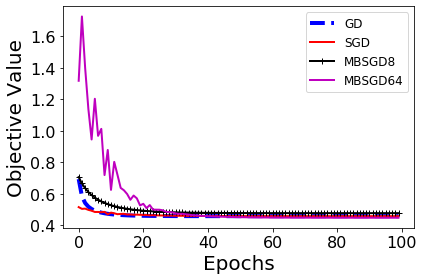

In [323]:
# plot the 4 curves:
#!/usr/bin/env python
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '-+k', LineWidth=2)
line3, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '-m', LineWidth=2)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD', 'MBSGD8','MBSGD64'], fontsize=12)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd_MBSGD.pdf', format='pdf', dpi=1200)